In [1]:
from classes.simulator import ALMONDOSimulator
from classes.almondoModel import AlmondoModel
import networkx as nx
import ndlib.models.ModelConfig as mc
import json
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

## Funzioni

In [2]:
def create_strategies(n_lobbyists: int, lobbyists_data: dict, N: int, nruns: int, strategies_path:str):
        """
        Generate and save strategies for the lobbyists.
        """
        print('Creating strategies')

        for id in range(n_lobbyists):
            data = lobbyists_data[id]
            B = data['B']
            c = data['c']
            folder = os.path.join(strategies_path, str(B))
            os.makedirs(folder, exist_ok=True)
            for run in range(nruns):
                filename = f'strategy_{run}.txt'
                path = os.path.join(folder, filename)
                if not os.path.exists(path):
                    inter_per_time = B // (c * 3000)
                    matrix = np.zeros((3000, N), dtype=int)
                    for t in range(3000):
                        indices = np.random.choice(N, inter_per_time, replace=False)
                        matrix[t, indices] = 1
                    print('Saving strategy to file')
                    np.savetxt(path, matrix, fmt="%i")
                else:
                    continue
        print('Strategies created')

In [3]:
def read_random_strategy(strategies_path, B: int) -> tuple:
        """
        Read a random strategy for a given B value.

        Arguments:
        - B: The B value associated with the lobbyist's strategy.

        Returns:
        - tuple: A tuple containing the strategy matrix and its filename.
        """
        path = os.path.join(strategies_path, str(B))
        strategy_name = random.choice(os.listdir(path))
        filepath = os.path.join(path, strategy_name)
        return np.loadtxt(filepath).astype(int), filepath

## Parametri

In [4]:
NLs = [0, 1, 2, 3, 4, 20] #number of lobbyists in the simulations
params = {
    'N': 500,
    'p_o': 0.01,
    'p_p': 0.99,
    'initial_distribution': 'uniform',
    'T': 10000,
    'lambda_values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'phi_values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'base': 'results_tests'
}    

In [5]:
nl = 2

params['scenario'] = f'balanced_budgets/{nl}_lobbyists'
params['n_lobbyists'] = nl

if nl > 0:
    params['lobbyists_data'] = dict()
    for id in range(nl):
        params['lobbyists_data'][id] = {'m': id%2, 'B': 300000, 'c': 1, 'strategies': [], 'T': 3000}    

os.makedirs(params['base'], exist_ok=True)
path = os.path.join(params['base'], params['scenario'])
os.makedirs(path, exist_ok=True)

with open(os.path.join(path, 'initial_config.json'), 'w') as f:
    json.dump(params, f, indent=4)

print(f'performing simulations for {params["scenario"]}')

performing simulations for balanced_budgets/2_lobbyists


## Simulator initialization

In [6]:
base_path = params['base']
scenario_path = os.path.join(params['base'], params['scenario'])
os.makedirs(base_path, exist_ok=True)
os.makedirs(scenario_path, exist_ok=True)
strategies_path = os.path.join(scenario_path, "strategies")
os.makedirs(strategies_path, exist_ok=True)        

N = params['N']
graph = nx.complete_graph(N)  # Create a complete graph of N nodes
p_o = params['p_o']
p_p = params['p_p']
lambdas = params['lambda_values']
phis = params['phi_values']
T = params['T']
initial_distribution = params['initial_distribution']
nruns = 1
lobbyists_data = params['lobbyists_data']
n_lobbyists = params['n_lobbyists']

if n_lobbyists > 0:
    create_strategies(n_lobbyists, lobbyists_data, N, nruns, strategies_path)  # Generate strategies for lobbyists if any exist

Creating strategies
Strategies created


## Create configuration in simulator

In [7]:
parameters_pairs = ([(l, p) for l in lambdas for p in phis])
print(parameters_pairs)

[(0.0, 0.0), (0.0, 0.1), (0.0, 0.2), (0.0, 0.3), (0.0, 0.4), (0.0, 0.5), (0.0, 0.6), (0.0, 0.7), (0.0, 0.8), (0.0, 0.9), (0.0, 1.0), (0.1, 0.0), (0.1, 0.1), (0.1, 0.2), (0.1, 0.3), (0.1, 0.4), (0.1, 0.5), (0.1, 0.6), (0.1, 0.7), (0.1, 0.8), (0.1, 0.9), (0.1, 1.0), (0.2, 0.0), (0.2, 0.1), (0.2, 0.2), (0.2, 0.3), (0.2, 0.4), (0.2, 0.5), (0.2, 0.6), (0.2, 0.7), (0.2, 0.8), (0.2, 0.9), (0.2, 1.0), (0.3, 0.0), (0.3, 0.1), (0.3, 0.2), (0.3, 0.3), (0.3, 0.4), (0.3, 0.5), (0.3, 0.6), (0.3, 0.7), (0.3, 0.8), (0.3, 0.9), (0.3, 1.0), (0.4, 0.0), (0.4, 0.1), (0.4, 0.2), (0.4, 0.3), (0.4, 0.4), (0.4, 0.5), (0.4, 0.6), (0.4, 0.7), (0.4, 0.8), (0.4, 0.9), (0.4, 1.0), (0.5, 0.0), (0.5, 0.1), (0.5, 0.2), (0.5, 0.3), (0.5, 0.4), (0.5, 0.5), (0.5, 0.6), (0.5, 0.7), (0.5, 0.8), (0.5, 0.9), (0.5, 1.0), (0.6, 0.0), (0.6, 0.1), (0.6, 0.2), (0.6, 0.3), (0.6, 0.4), (0.6, 0.5), (0.6, 0.6), (0.6, 0.7), (0.6, 0.8), (0.6, 0.9), (0.6, 1.0), (0.7, 0.0), (0.7, 0.1), (0.7, 0.2), (0.7, 0.3), (0.7, 0.4), (0.7, 0.5), (0.

In [8]:
lambda_v = parameters_pairs[0][0]
phi_v = parameters_pairs[0][1]

print('Creating configuration object')
config = mc.Configuration()

print('Assigning p_o and p_p parameters')
config.add_model_parameter("p_o", p_o)
config.add_model_parameter("p_p", p_p)
print(f'p_o={p_o}, p_p={p_p}')

# Configure lambda values for each agent
if isinstance(lambda_v, list):
    for i in graph.nodes():
        config.add_node_configuration("lambda", i, lambda_v[i])
elif isinstance(lambda_v, float):
    print('Assigning homogeneous lambda')
    for i in graph.nodes():
        config.add_node_configuration("lambda", i, lambda_v)
else:
    raise ValueError("lambda_v must be a float or a list")

# Configure phi values for each agent
if isinstance(phi_v, list):
    for i in graph.nodes():
        config.add_node_configuration("phi", i, phi_v[i])
elif isinstance(phi_v, float):
    print('Assigning homogeneous phi')
    for i in graph.nodes():
        config.add_node_configuration("phi", i, phi_v)
else:
    raise ValueError("phi_v must be a float or a list")

# Initialize the model with the graph and configuration
print('Configuring model: assigning graph, parameters, and initial distribution of weights')
model = AlmondoModel(graph)

Creating configuration object
Assigning p_o and p_p parameters
p_o=0.01, p_p=0.99
Assigning homogeneous lambda
Assigning homogeneous phi
Configuring model: assigning graph, parameters, and initial distribution of weights


In [9]:
model.set_initial_status(config, kind=initial_distribution)
print('Initial status set')

Initial status set


In [10]:
print(model.status)

[0.73178543 0.89153765 0.75298027 0.35569571 0.61252881 0.39126331
 0.44356543 0.88106443 0.35378975 0.491891   0.39989255 0.74360797
 0.24376814 0.81198989 0.34915747 0.44201758 0.64336359 0.64766521
 0.87785684 0.39151317 0.17657395 0.95541323 0.55097127 0.30612241
 0.24197823 0.06660972 0.13586358 0.45889085 0.68527841 0.34686521
 0.2342199  0.68683494 0.2739278  0.19197643 0.79039017 0.1575009
 0.12869725 0.57378025 0.77201548 0.1528822  0.59650702 0.33944867
 0.67030575 0.72442655 0.78996756 0.06657104 0.08160602 0.42493914
 0.80609975 0.0034341  0.36795559 0.37493754 0.55083308 0.17661036
 0.57828853 0.05395347 0.7297662  0.49638928 0.85628415 0.81939297
 0.29217109 0.20369362 0.48829902 0.50728495 0.1503873  0.6035176
 0.82897618 0.39111987 0.52831004 0.00137441 0.83308554 0.31352917
 0.8200274  0.56037534 0.85626695 0.75975123 0.04965687 0.3471029
 0.46043712 0.92516    0.07164767 0.37789338 0.67031891 0.67217673
 0.19724256 0.27601909 0.57216083 0.37886095 0.48388526 0.0998600

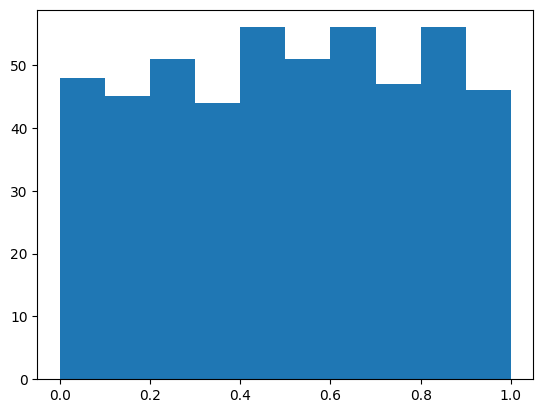

In [11]:
distrib = np.random.uniform(low=0, high=1, size=N)
plt.hist(distrib, bins=10)
plt.show()

#### La funzione iniziale su 100 run genera distribuzioni con media 0.5?

In [12]:
avg_ops = []

for _ in range(100):
    distrib = np.random.uniform(0, 1, N)
    avg_opinion = np.mean(distrib)
    print(avg_opinion)
    avg_ops.append(avg_opinion)

sum(avg_ops)/len(avg_ops)

0.511929159708552
0.5004569157169086
0.48852815988866727
0.4984218692306608
0.494500592356067
0.514008611310629
0.4834342333907774
0.49813066625270325
0.5025034667586238
0.4933643594669837
0.4995200781522488
0.5035822507426433
0.49394857653087026
0.48315820670422793
0.5053968520999754
0.49366991789666836
0.5016900964440879
0.4991151676192907
0.4954959715051614
0.5096433484744162
0.5028412523417257
0.5088721114946382
0.4989225422494581
0.4886401606568462
0.49203906073683606
0.5040524664107258
0.5186323787913993
0.49683116371220887
0.4973404813622285
0.5045211025993066
0.4999518209860914
0.4978281550358563
0.5441433091400777
0.5105027775215222
0.4958423811365159
0.49325175952633865
0.5008130824786503
0.48174909735415455
0.5060599919585254
0.49156720985892216
0.4927882494636239
0.4973952816065715
0.4851764261344977
0.5081497921780338
0.5051800591879718
0.4915661212254113
0.4953165050317566
0.5175612238377483
0.5035285983589374
0.49441329187393923
0.5094642888944282
0.5066439290121785
0.47

np.float64(0.49917005975501416)

In [13]:
print(model.lambdas)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [14]:
print(model.phis)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [15]:
print(model.lobbyists)

[]


In [16]:
print(model.system_status)

[]


In [17]:
print('Assign strategies to lobbyists if any')
if n_lobbyists > 0:
    for id in tqdm(lobbyists_data):
        data = lobbyists_data[id]
        B = data['B']
        print(B)
        m = data['m']
        matrix, name = read_random_strategy(strategies_path, B)
        model.add_lobbyist(m, matrix)
        lobbyists_data[id]['strategies'].append(name)

print('Configuration ended')

Assign strategies to lobbyists if any


  0%|          | 0/2 [00:00<?, ?it/s]

300000
300000


100%|██████████| 2/2 [00:00<00:00, 13.09it/s]

Configuration ended


In [18]:
print(model.lobbyists)

[<classes.almondoModel.AlmondoModel.LobbyistAgent object at 0x7747cd0d4cd0>, <classes.almondoModel.AlmondoModel.LobbyistAgent object at 0x77478c592650>]


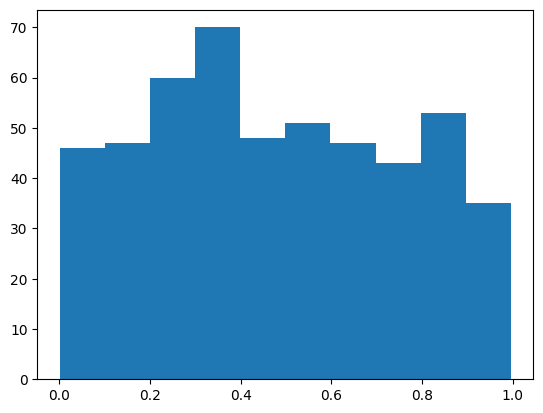

In [19]:
plt.hist(model.status)
plt.show()

In [20]:
system_status = []

In [21]:
actual_iteration = 0

## Interazione con il lobbista

(array([  1.,   1.,   0.,   0.,   0.,   5.,   2.,   8.,  22., 461.]),
 array([0.11991531, 0.20792345, 0.2959316 , 0.38393974, 0.47194789,
        0.55995603, 0.64796418, 0.73597232, 0.82398047, 0.91198861,
        0.99999676]),
 <BarContainer object of 10 artists>)

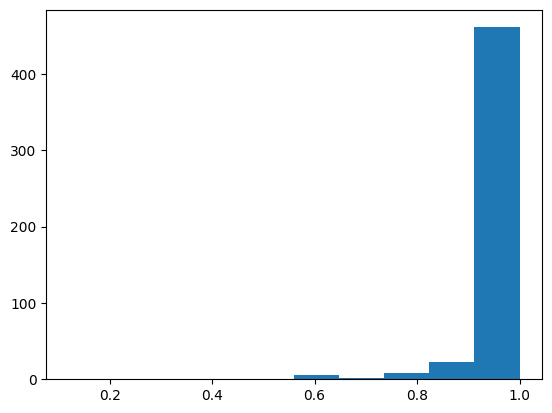

In [30]:
plt.hist(model.status)

In [31]:
model.actual_iteration

2

In [32]:
model.actual_status = model.status.copy()

if model.actual_iteration == 0:
    model.actual_iteration += 1
    its = {"iteration": 0, "status": {i: value for i, value in enumerate(model.actual_status)}}
    system_status.append(its)

p_o = model.params['model']['p_o']
p_p = model.params['model']['p_p']

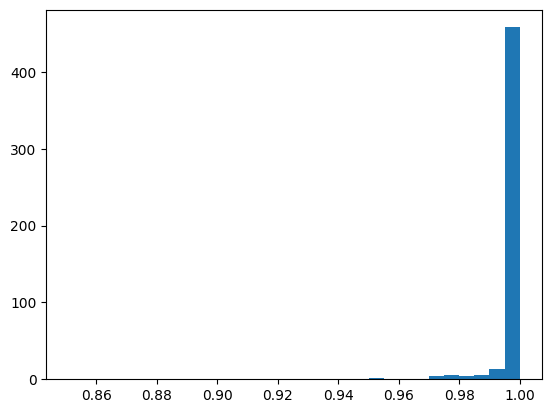

In [38]:
lobbyist_list = model.lobbyists.copy()
                
random.shuffle(lobbyist_list)

if len(model.lobbyists) > 0:
    for lobbyist in lobbyist_list:
        if model.actual_iteration < lobbyist.max_t:
            w = model.lupdate(model.actual_status, lobbyist, model.actual_iteration)

model.actual_status = w.copy()

plt.hist(model.actual_status, bins=30)
plt.show()


In [39]:
sender = random.randint(0, model.n - 1)
print('sender ', sender)

try:        
    p = model.actual_status[sender] * p_o + (1 - model.actual_status[sender]) * p_p
    print('p ', p)
    assert(p >= 0 and p <= 1), f"Probability should be between 0 and 1, not {p}."
    signal = np.random.binomial(1, p)
    print('signal ', signal)
    assert(signal == 0 or signal == 1), f"Signal should be 0 or 1, not {signal}."

except ValueError as e:
    print('Info about code that causes the error -->')
    print('Error = ', e)
    print('p = ', p)
    print('sender = ', sender)
    print('sender actual status = ', model.actual_status[sender])
    
receivers = np.array(list(model.graph.neighbors(sender)))

sender  86
p  0.01007476269860443
signal  0


### Update functions

## Interazione con il sender

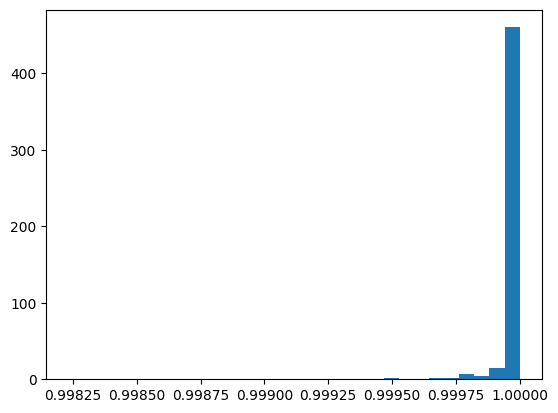

In [40]:
if len(receivers) > 0:
    model.actual_status[receivers] = model.update(receivers=receivers, s=signal)

assert(np.all(model.actual_status >= 0) and np.all(model.actual_status <= 1)), "Status values should be between 0 and 1."
assert(len(model.actual_status) == model.n), f"Length of actual_status {len(model.actual_status)} does not match the number of nodes {self.n}."

model.actual_iteration += 1
model.status = model.actual_status

plt.hist(model.actual_status, bins=30)
plt.show()

its = {"iteration": model.actual_iteration - 1, "status": {i: value for i, value in enumerate(model.actual_status)}}

In [41]:
system_status.append(its)

In [42]:
len(system_status)

4